In [37]:
import os
import pyedflib
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.signal import lombscargle, savgol_filter

# Individual Analysis 

This Jupyter Notebook outlines the process of extracting HRV metrics from the ECG channels of an EDF file for a **single subject**.
It includes multiple displays and visualizations at each step to ensure accurate HRV metric extraction and thorough verification of the process.


In [38]:
# Please put the path of the Assignment Folder
assignment_folder_path = "/Users/alicealbrecht/Desktop/DrLeng_assignment"
selected_subject = "200603"

# Please adjust the window used to plot a subset of the ECG signal
min_range = 6250
length_range = 5

## 1. Load EDF File and Extract ECG Channel

In this section, we load an EDF file and extract the ECG channel. The ECG signal is inverted to align with the conventional ECG waveform orientation (where the P-wave has an upward deflection).


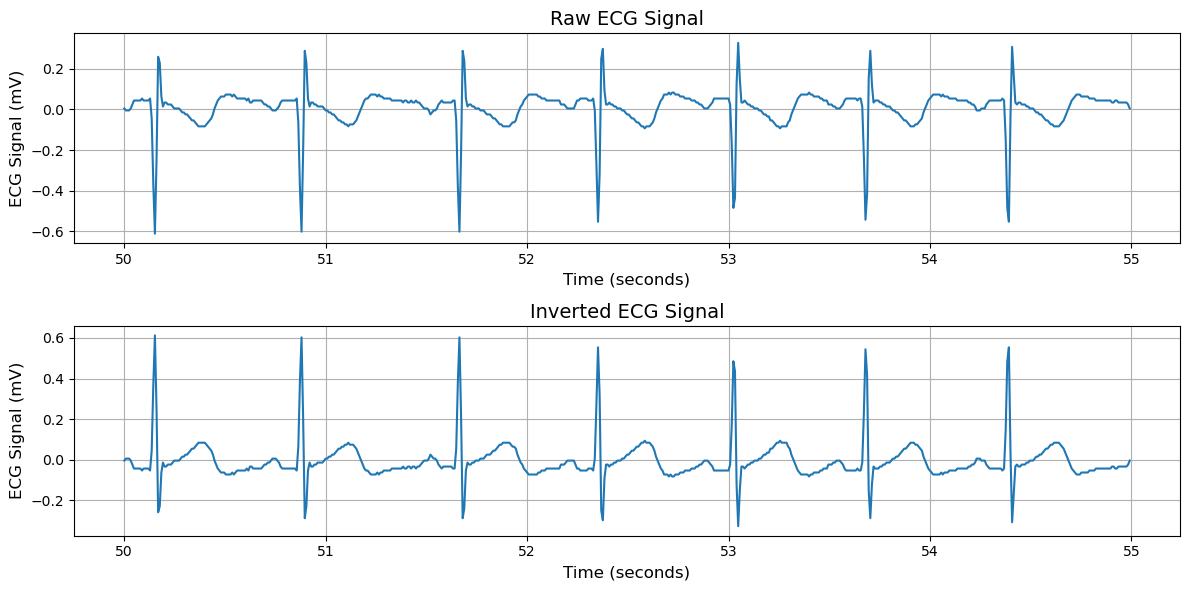

In [39]:
# Define function to extract ECG signal from EDF
def extract_ecg_signal(edf_file):
    """
    Extracts ECG signal from an EDF file and inverts it to match conventional ECG orientation.

    Parameters:
    - edf_file (str): Path to the EDF file containing the ECG signal.

    Returns:
    - ecg_signal_raw (numpy.ndarray): Raw ECG signal.
    - ecg_signal (numpy.ndarray): Inverted ECG signal.
    - sample_rate (float): Sample rate of the ECG signal (in Hz).
    """
    with pyedflib.EdfReader(edf_file) as f:
        signal_labels = f.getSignalLabels()
        ecg_index = None
        # Search for ECG signal in the file
        for i, label in enumerate(signal_labels):
            if 'ECG' in label.upper():
                ecg_index = i
                break
        else:
            raise ValueError(f"No ECG signal found in {edf_file}. Cannot proceed.")
        
        ecg_signal_raw = f.readSignal(ecg_index)
        sample_rate = f.getSampleFrequency(ecg_index)

    # Invert ECG signal to match conventional orientation
    ecg_signal = -ecg_signal_raw
    return ecg_signal_raw, ecg_signal, sample_rate

# Load the EDF file
edf_file = os.path.join(assignment_folder_path, f'dataset/shhs1-{selected_subject}.edf')
ecg_signal_raw, ecg_signal, sample_rate = extract_ecg_signal(edf_file)

# Plotting both raw and inverted ECG signals for a small time interval
time = np.arange(len(ecg_signal)) / sample_rate
max_range = int(min_range + length_range * sample_rate)  # Plot 5 seconds of the signal

plt.figure(figsize=(12, 6))

# Raw ECG signal
plt.subplot(2, 1, 1)
plt.plot(time[min_range:max_range], ecg_signal_raw[min_range:max_range])  
plt.title("Raw ECG Signal", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("ECG Signal (mV)", fontsize=12)
plt.grid(True)

# Inverted ECG signal
plt.subplot(2, 1, 2)
plt.plot(time[min_range:max_range], ecg_signal[min_range:max_range])  
plt.title("Inverted ECG Signal", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("ECG Signal (mV)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

## 2. Preprocessing of ECG Signal

The ECG signal has been pre-processed using a **0.15 Hz high-pass filter**, as described in the [SHHS1 Equipment Documentation](https://sleepdata.org/datasets/shhs/pages/08-equipment-shhs1.md), to remove baseline drift. This baseline drift can arise from various sources such as body movements, respiration, and low-frequency noise, which can interfere with the quality of the signal.

Further preprocessing was carried out using NeuroKit's `ecg_clean` tool. This tool performs several cleaning steps, including:
- Removal of noise from muscle artifacts
- Removal of low-frequency baseline drift
- Other signal clean-up tasks to make the ECG signal more suitable for analysis.

For more details on the `ecg_clean` function, refer to the [NeuroKit2 documentation](https://neuropsychology.github.io/NeuroKit/functions/ecg.html).

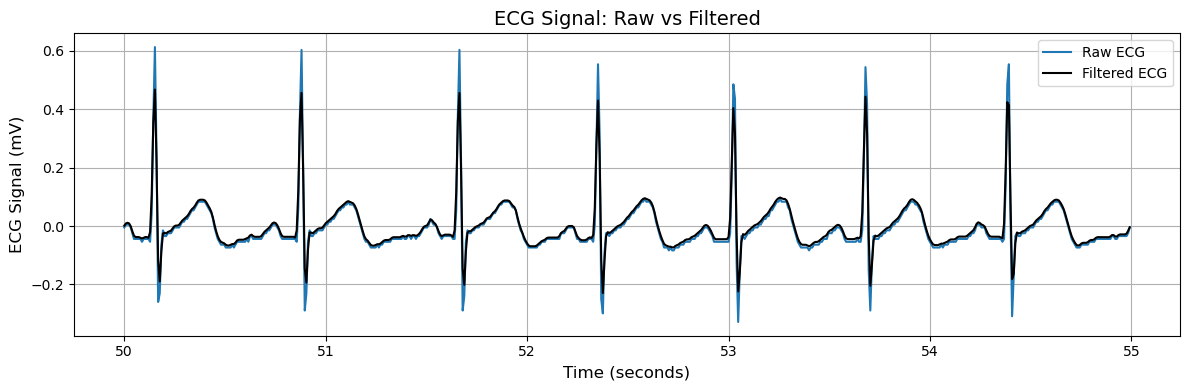

In [40]:
# Preprocessing the ECG signal using NeuroKit's ecg_clean function
filtered_ecg_signal = nk.ecg_clean(ecg_signal, sample_rate)

# Plotting both the raw and filtered ECG signals for comparison
plt.figure(figsize=(12, 4))
plt.plot(time[min_range:max_range], ecg_signal[min_range:max_range], label="Raw ECG") # raw ECG
plt.plot(time[min_range:max_range], filtered_ecg_signal[min_range:max_range], label="Filtered ECG", color="black") # filtered EDG

# Adding plot details
plt.title("ECG Signal: Raw vs Filtered", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("ECG Signal (mV)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Temporal Analysis for Deriving Temporal HRV Metrics

The RR intervals were computed using **NeuroKit**'s `ecg_findpeaks` function, which detects R-peaks in the ECG signal. The computation might be long because multiple techniques are computed: Probabilistic Methods-Agreement via Convolution (ProMAC). R-peaks are the sharpest points in the ECG signal and are used to calculate the RR intervals. These intervals represent the time difference between two successive R-peaks. To ensure the quality of the analysis, we removed any abnormal RR intervals that exceeded 2.5 seconds. The remaining intervals are referred to as NN intervals.

More details on HRV analysis can be found in the [HRV Analysis Documentation on the SHHS Dataset](https://sleepdata.org/datasets/shhs/pages/13-hrv-analysis.md).

Number of abnormal RR found: 0


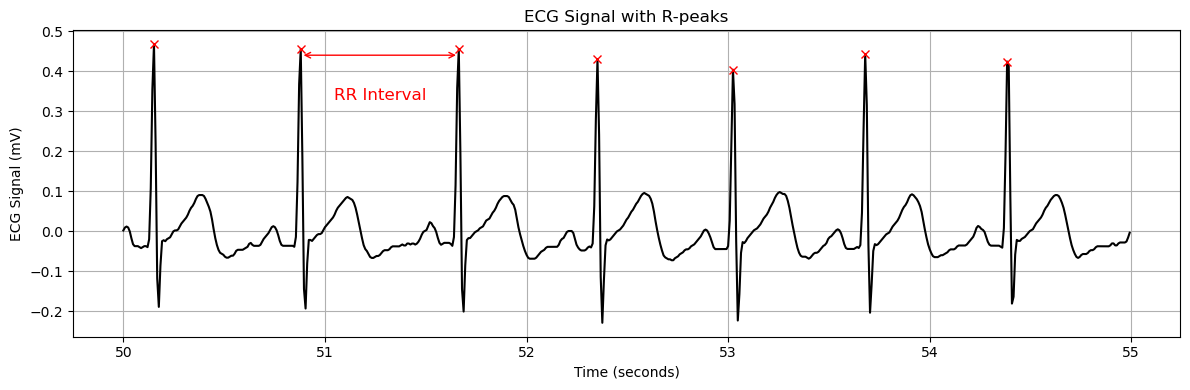

In [46]:
# Function to get R-peaks from ECG signal using NeuroKit's ecg_findpeaks
def get_r_peaks(ecg_signal, sample_rate):
    # Using multiple methods for R-peak detection
    ecg_peaks = nk.ecg_findpeaks(ecg_signal, 
                                 sampling_rate=sample_rate, 
                                 method="promac",
                                 promac_methods=["neurokit",
                                                  "slopesumfunction",
                                                  "engzee2012",
                                                  "kalidas2017",
                                                  "nabian2018",
                                                  "rodrigues2021",
                                                  "kalidas2017"])
    r_peaks = ecg_peaks['ECG_R_Peaks']
    return r_peaks

# Get R-peaks from the filtered ECG signal
r_peaks = get_r_peaks(filtered_ecg_signal, sample_rate)

# Calculate RR intervals in seconds
rr_intervals = np.diff(r_peaks) / sample_rate

# Remove abnormal intervals greater than 2.5 seconds
nn_intervals = rr_intervals[rr_intervals <= 2.5]
print(f"Number of abnormal RR found: {len(rr_intervals) - len(nn_intervals)}")

# Plot ECG signal and detected R-peaks
plt.figure(figsize=(12, 4))
plt.plot(time[min_range:max_range], filtered_ecg_signal[min_range:max_range], color="k", label='Filtered ECG Signal')  # Filtered ECG signal

# Filter peaks to fit within the plotted range
peaks_in_range = r_peaks[(r_peaks >= min_range) & (r_peaks < max_range)]
peaks_in_time = time[peaks_in_range]

# Plot the R-peaks
plt.plot(peaks_in_time, filtered_ecg_signal[peaks_in_range], 'rx', label='R-peaks')

# Annotate the RR interval between the first two peaks
x_start = peaks_in_time[1]
x_end = peaks_in_time[2]
y_value = np.mean(filtered_ecg_signal[peaks_in_range])
plt.annotate('', xy=(x_end, y_value), xytext=(x_start, y_value),
             arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='<->'))
midpoint_x = (x_start + x_end) / 2
plt.text(midpoint_x, y_value - 0.1, 'RR Interval', ha='center', va='center', fontsize=12, color='red')

plt.title(f"ECG Signal with R-peaks")
plt.xlabel("Time (seconds)")
plt.ylabel("ECG Signal (mV)")
plt.grid()
plt.tight_layout()
plt.show()

These NN intervals were used to compute the following key temporal HRV metrics:
- `AVNN` The average of all NN intervals, providing an overall measure of heart rate.
- `SDNN` The standard deviation of NN intervals, indicating the overall variability in heart rate.
- `rMSSD` The square root of the mean of the squared differences between adjacent NN intervals, reflecting short-term heart rate variability.
- `pNN50` The percentage of pairs of adjacent NN intervals that differ by more than 50 ms, serving as a measure of the frequency of large fluctuations in heart rate.

To check my results, I compare with the `nk.hrv_time` function outputs from **NeuroKit**.

HRV Metrics (Temporal Analysis):
AVNN: 747.057 ms
SDNN: 76.653 ms
RMSSD: 59.366 ms
pNN50: 19.019 %
AVNN (NeuroKit): 747.057 ms
SDNN (NeuroKit): 76.654 ms
RMSSD (NeuroKit): 59.366 ms
pNN50 (NeuroKit): 19.019 %


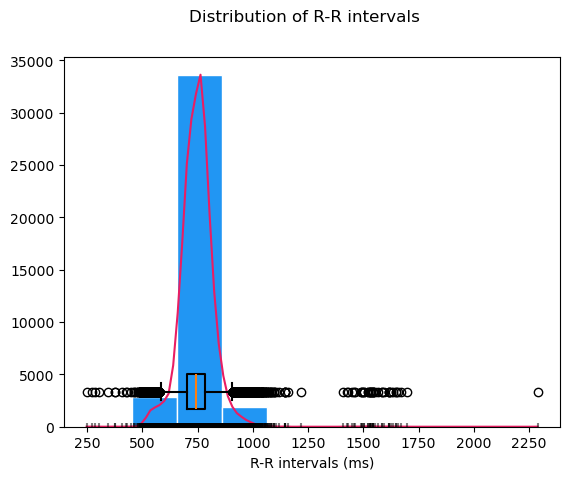

In [42]:
# Calculate temporal HRV metrics
avnn = np.mean(nn_intervals) * 1000  # AVNN (Average of all NN intervals)
sdnn = np.std(nn_intervals) * 1000  # SDNN (Standard deviation of NN intervals)
rmssd = np.sqrt(np.mean(np.diff(nn_intervals) ** 2)) * 1000  # RMSSD (Root Mean Square of Successive Differences)
nn50 = np.sum(np.abs(np.diff(nn_intervals)) > 0.05)  # pNN50 (Percentage of NN intervals > 50 ms)
pnn50 = (nn50 / len(nn_intervals)) * 100  # pNN50 as a percentage

# Print the calculated HRV metrics
print("HRV Metrics (Temporal Analysis):")
print(f"AVNN: {avnn:.3f} ms")
print(f"SDNN: {sdnn:.3f} ms")
print(f"RMSSD: {rmssd:.3f} ms")
print(f"pNN50: {pnn50:.3f} %")

# Alternatively, use NeuroKit's built-in function to calculate HRV metrics
hrv_metrics_time = nk.hrv_time(r_peaks, sampling_rate=sample_rate, show=True)

# Display the metrics from NeuroKit
print(f"AVNN (NeuroKit): {hrv_metrics_time['HRV_MeanNN'][0]:.3f} ms")
print(f"SDNN (NeuroKit): {hrv_metrics_time['HRV_SDNN'][0]:.3f} ms")
print(f"RMSSD (NeuroKit): {hrv_metrics_time['HRV_RMSSD'][0]:.3f} ms")
print(f"pNN50 (NeuroKit): {hrv_metrics_time['HRV_pNN50'][0]:.3f} %")

## 4. Frequency Analysis for Deriving HRV Frequency Metrics

Frequency analysis is used to transform the **NN intervals** from the time domain into the frequency domain, allowing us to analyze the heart’s rhythm variations across different frequencies. This transformation is achieved using the **Lomb-Scargle Periodogram**, a method that is well-suited for unevenly spaced data, such as RR intervals, as opposed to the Fast Fourier Transform (FFT), which requires evenly spaced data. The Lomb-Scargle method is preferred here because it does not rely on interpolation and can handle the irregular nature of the RR intervals without distorting the results.

The **Power Spectral Density (PSD)** represents the distribution of signal power across different frequencies. It is essential for identifying dominant frequencies and their associated power within the signal. Once we have obtained the PSD, we calculate several key **Heart Rate Variability (HRV)** frequency metrics to evaluate the autonomic nervous system’s regulation of heart rate.

The key HRV frequency metrics include:
- `ULF (Ultra Low Frequency)` [0.003-0.01]Hz, May represent very slow regulatory mechanisms.
- `VLF (Very Low Frequency)` [0.01-0.04]Hz: Reflect slow regulatory processes such as blood pressure control and thermoregulation.
- `LF (Low Frequency)` [0.04-0.15]Hz: Associated with both sympathetic and parasympathetic nervous system activity.
- `HF (High Frequency)` [0.15-0.4]Hz: Primarily reflecting parasympathetic activity and commonly linked to respiratory sinus arrhythmia (respiration-related heart rate variation).
- `VHF (Very High Frequency)` [0.4-0.5]Hz Reflecting high-frequency fluctuations related to very short-term regulatory processes.


HRV Metrics (Spectral Analysis):
ULF (Ultra Low Frequency): 11.671 %
VLF (Very Low Frequency): 27.892 %
LF (Low Frequency): 21.435 %
HF (High Frequency): 29.243 %
VHF (Very High Frequency): 6.383 %
LF/HF ratio: 0.733


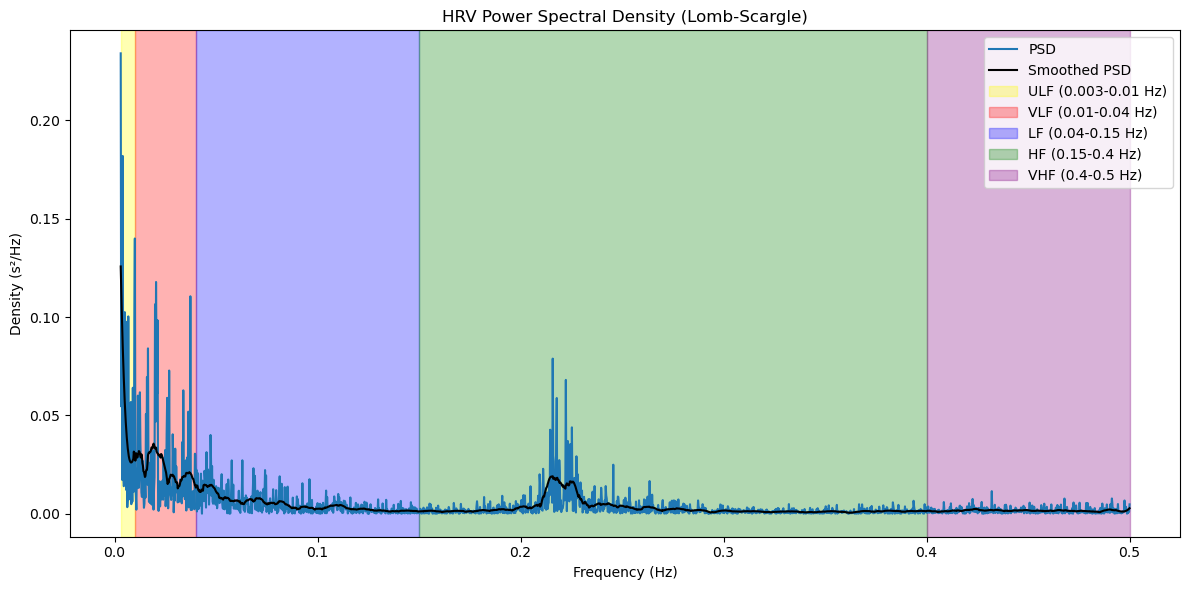

In [43]:
# Compute cumulative time (in seconds)
t_original = np.cumsum(nn_intervals) 

# Define frequency range 
frequencies = np.linspace(0.003, 0.5, 2000)  
angular_freqs = 2 * np.pi * frequencies  # Convert to angular frequency (rad/s)

# Compute Lomb-Scargle Periodogram
psd = lombscargle(t_original, nn_intervals - np.mean(nn_intervals), angular_freqs, normalize="power", floating_mean=True)

# Define frequency bands for ULF, VLF, LF, HF, VHF
ULF_band = (0.0033, 0.01)  
VLF_band = (0.01, 0.04)  
LF_band = (0.04, 0.15)    
HF_band = (0.15, 0.4)     
VHF_band = (0.4, 0.5)   

# Integrate power using the trapezoidal rule for better accuracy
TOTPWR = np.trapezoid(psd, frequencies)  # Integrating over the entire frequency range

# Compute power in the frequency bands
ULF = np.trapezoid(psd[(frequencies >= ULF_band[0]) & (frequencies <= ULF_band[1])], frequencies[(frequencies >= ULF_band[0]) & (frequencies <= ULF_band[1])])
VLF = np.trapezoid(psd[(frequencies >= VLF_band[0]) & (frequencies <= VLF_band[1])], frequencies[(frequencies >= VLF_band[0]) & (frequencies <= VLF_band[1])])
LF = np.trapezoid(psd[(frequencies >= LF_band[0]) & (frequencies <= LF_band[1])], frequencies[(frequencies >= LF_band[0]) & (frequencies <= LF_band[1])])
HF = np.trapezoid(psd[(frequencies >= HF_band[0]) & (frequencies <= HF_band[1])], frequencies[(frequencies >= HF_band[0]) & (frequencies <= HF_band[1])])
VHF = np.trapezoid(psd[(frequencies >= VHF_band[0]) & (frequencies <= VHF_band[1])], frequencies[(frequencies >= VHF_band[0]) & (frequencies <= VHF_band[1])])

# Normalize power in each band relative to total power (as percentage)
ULF_norm = ULF / TOTPWR * 100
VLF_norm = VLF / TOTPWR * 100
LF_norm = LF / TOTPWR * 100
HF_norm = HF / TOTPWR * 100
VHF_norm = VHF / TOTPWR * 100

# Calculate LF/HF ratio (avoid division by zero)
LF_HF_ratio = LF / HF if HF != 0 else np.nan

# Print HRV Metrics
print("HRV Metrics (Spectral Analysis):")
print(f"ULF (Ultra Low Frequency): {ULF_norm:.3f} %")
print(f"VLF (Very Low Frequency): {VLF_norm:.3f} %")
print(f"LF (Low Frequency): {LF_norm:.3f} %")
print(f"HF (High Frequency): {HF_norm:.3f} %")
print(f"VHF (Very High Frequency): {VHF_norm:.3f} %")
print(f"LF/HF ratio: {LF_HF_ratio:.3f}")

# Smooth for plot
psd_smooth = savgol_filter(psd, window_length=51, polyorder=3)  # Smoothing window

# Plot the PSD with the threshold applied
plt.figure(figsize=(12, 6))
plt.plot(frequencies, psd, label="PSD")
plt.plot(frequencies, psd_smooth, label="Smoothed PSD", color="black")

# Plot the frequency bands (ULF, VLF, LF, HF, VHF)
plt.axvspan(*ULF_band, color='yellow', alpha=0.3, label="ULF (0.003-0.01 Hz)")
plt.axvspan(*VLF_band, color='red', alpha=0.3, label="VLF (0.01-0.04 Hz)")
plt.axvspan(*LF_band, color='blue', alpha=0.3, label="LF (0.04-0.15 Hz)")
plt.axvspan(*HF_band, color='green', alpha=0.3, label="HF (0.15-0.4 Hz)")
plt.axvspan(*VHF_band, color='purple', alpha=0.3, label="VHF (0.4-0.5 Hz)")

# Plot labels and title
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density (s²/Hz)")
plt.legend()
plt.title("HRV Power Spectral Density (Lomb-Scargle)")
plt.tight_layout()

# Show the plot
plt.show()

## Poincaré Plot and Non-Linear HRV Metrics (SD1 and SD2)

The Poincaré plot is a visual tool used to evaluate heart rate variability (HRV) in the time domain. It displays the relationship between successive **NN intervals**, providing insights into the nonlinear aspects of the heart's rhythm. The plot can help reveal patterns that are not captured by traditional linear methods, such as frequency domain analysis.

In addition to the plot, two important measures—**SD1** and **SD2**—are computed. These values represent the standard deviations of the points along the axes of the ellipse fitted to the Poincaré plot. SD1 quantifies the short-term variability, and SD2 quantifies the long-term variability of the NN intervals.

The following code calculates these values and visualizes them with the Poincaré plot, where the ellipse and arrows indicate the directions and strengths of the short-term and long-term HRV.

SD1: 41.978
SD2: 99.947


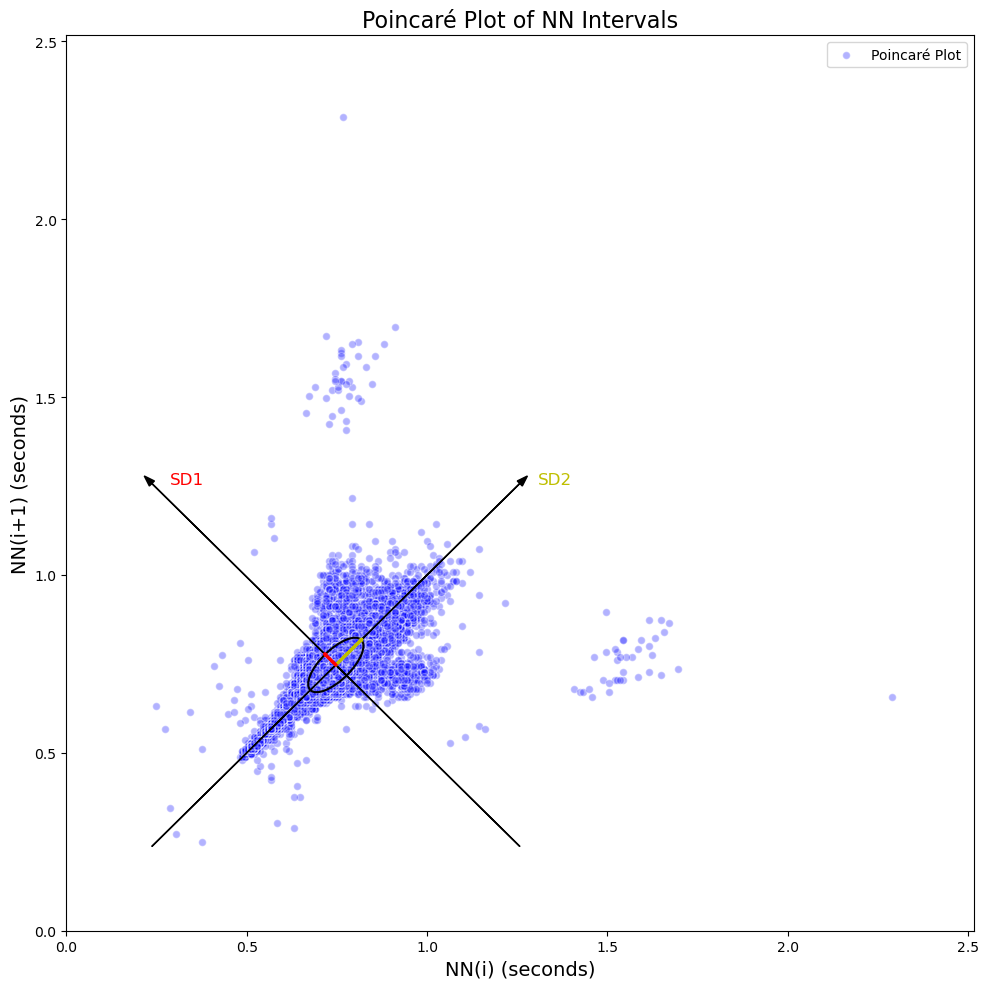

In [44]:
# Calculate SD1 and SD2 (nonlinear HRV measures)
# SD1: Short-term variability, perpendicular to the axis of the ellipse
# SD2: Long-term variability, along the axis of the ellipse
SD1 = np.sqrt(0.5) * np.std(nn_intervals[1:] - nn_intervals[:-1]) # Short-term HRV
SD2 = np.sqrt(0.5) * np.std(nn_intervals[1:] + nn_intervals[:-1]) # Long-term HRV

# Display SD1 and SD2
print(f"SD1: {SD1*1000:.3f}")
print(f"SD2: {SD2*1000:.3f}")

# Create the Poincaré plot
plt.figure(figsize=(10, 10))  # Adjust figure size for better clarity
plt.scatter(nn_intervals[:-1], nn_intervals[1:], color='blue', edgecolor='white', label="Poincaré Plot", s=30, alpha=0.3)

# Title and axis labels
plt.title("Poincaré Plot of NN Intervals", fontsize=16)
plt.xlabel("NN(i) (seconds)", fontsize=14)
plt.ylabel("NN(i+1) (seconds)", fontsize=14)

# Add the Ellipse (representing SD1 and SD2)
m = np.mean(nn_intervals)  # Mean of NN intervals for ellipse center
ellipse = Ellipse((m, m), 2*SD1, 2*SD2, angle=-45, linewidth=1.5, fill=False, color="k")  # Ellipse showing variability
plt.gca().add_patch(ellipse)

# Add arrows indicating SD1 and SD2
arrow_length = (np.max(nn_intervals) - np.min(nn_intervals)) * 0.5  # Arrow length based on data range
plt.arrow(m - arrow_length / 2, m - arrow_length / 2, arrow_length, arrow_length, color="k", linewidth=1, head_width=0.02)
plt.arrow(m + arrow_length / 2, m - arrow_length / 2, -arrow_length, arrow_length, color="k", linewidth=1, head_width=0.02)

# Arrows indicating SD1 (red) and SD2 (yellow)
plt.arrow(m, m, SD2 * np.sqrt(0.5), SD2 * np.sqrt(0.5), color="y", linewidth=2)  # Long-term variability (SD2)
plt.arrow(m, m, -SD1 * np.sqrt(0.5), SD1 * np.sqrt(0.5), color="red", linewidth=2)  # Short-term variability (SD1)

# Annotate SD1 and SD2
plt.text(m - arrow_length / 2 + 0.05, m + arrow_length / 2, "SD1", fontsize=12, color="r")
plt.text(m + arrow_length / 2 + 0.05, m + arrow_length / 2, "SD2", fontsize=12, color="y")

# Set axis limits to ensure the plot starts at 0 for better clarity
plt.xlim(0, max(nn_intervals) * 1.1)  # Added margin for better visualization
plt.ylim(0, max(nn_intervals) * 1.1)  # Same margin for Y-axis

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()  # Ensure everything fits within the figure
plt.show()

## References

1. [SHHS1 Equipment Documentation](https://sleepdata.org/datasets/shhs/pages/08-equipment-shhs1.md)
2. [NeuroKit2 documentation](https://neuropsychology.github.io/NeuroKit/functions/ecg.html)
3. [HRV Analysis Documentation on SHHS Dataset](https://sleepdata.org/datasets/shhs/pages/13-hrv-analysis.md)